# Overview

This tutorial goes over a use-case for the OCSMesh tool for subsetting and combining two meshes in a given domain. Both meshes cover more or less the same region, but one has a higher resolution that the other. The idea is to use elements from the higher resolution mesh in a "region of interest" where we want to get more accurate results.

The usecase discussed here is for Hurricane Ian. This storm was a Category 5 Atlantic hurricane, between Sep 21, 2022 and Oct 1, 2022. We'd like the higher resolution mesh be concentrated in the zone of most flooding impact. We define it (for meshing purposes) to be the coastal area within the 34kt wind region.

This region of impact is defined by the input "region of interest" shapefile along with the cutoff depth (to define coastal region). The same script used in this tutorial can be utilized along with an arbitrary shape and very high cutoff depth to subset two meshes arbitrarily!

The two meshes can be downloaded from ... (to be shared)

In [1]:
import os
import tempfile
import pathlib
from copy import deepcopy
from pathlib import Path 
from datetime import datetime, timedelta

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from cartopy.feature import NaturalEarthFeature
from rasterio.plot import show as rioshow
from shapely.geometry import Polygon
from matplotlib import pyplot
from pyproj import CRS
from shapely import geometry, ops
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize, LogNorm
from matplotlib.colors import LinearSegmentedColormap


import ocsmesh
import pyschism
import pyschism.driver
from stormevents.nhc import nhc_storms, VortexTrack
from stormevents import StormEvent
from pyschism.mesh import Hgrid, gridgr3
from pyschism.forcing.nws import ERA5, BestTrackForcing

Define paths to data locations

In [2]:
path_subset_rasters = [
    '/mnt/c/Users/Soroosh.Mani/WorkArea/Testing/DEM/GEBCO/gebco_2020_n90.0_s0.0_w-180.0_e-90.0.tif',
    '/mnt/c/Users/Soroosh.Mani/WorkArea/Testing/DEM/GEBCO/gebco_2020_n90.0_s0.0_w-90.0_e0.0.tif',
]
path_subset_hi_mesh = '/mnt/c/Users/Soroosh.Mani/WorkArea/Testing/Grid/HSOFS_250m_v1.0_fixed.14'
path_subset_lo_mesh = '/mnt/c/Users/Soroosh.Mani/WorkArea/Testing/Grid/WNAT_1km.14'
path_subset_roi = 'region_of_interest'
path_subset_outdir = Path('./mesh')

path_subset_outdir.mkdir(exist_ok=True)

Defining utility functions used in this notebook

In [3]:
def plot_mesh_edge(msh_t_obj, ax=None, **kwargs):
    crd = msh_t_obj.vert2['coord']
    cnn = msh_t_obj.tria3['index']
    
    if ax == None:
        fig, ax = plt.subplots()
    ax.triplot(crd[:, 0], crd[:, 1], cnn, **kwargs)
    ax.set_aspect(1)
    return ax

In [4]:
storm = StormEvent('ian', 2022)
storm

/home/smani/workarea/sandbox/stormevents/stormevents/nhc/storms.py:64: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  storms = pandas.read_csv(


StormEvent(name='IAN', year=2022, start_date=Timestamp('2022-09-21 06:00:00'), end_date=Timestamp('2022-10-01 06:00:00'))

Get the best track data of Hurricane Ian, and write it into file (hurricane-track.dat)

In [5]:
storm_best_track = storm.track()
storm_best_track.to_file('hurricane-track.dat')

skipping existing file "hurricane-track.dat"


In [6]:
gdf_countries = gpd.GeoSeries(NaturalEarthFeature(category='physical', scale='10m', name='land').geometries(), crs=4326)

Plot the best track and `34`/`50`/`64`$kt$ wind swath around best track

Text(0.5, 1.0, 'IAN 2022 CO-OPS maximum water levels')

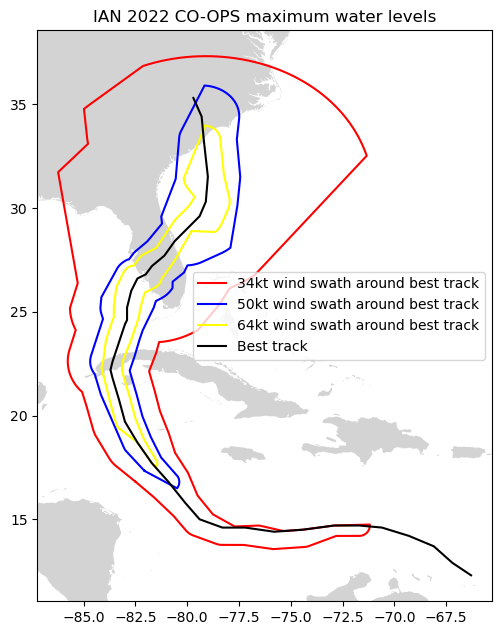

In [7]:
figure, axis = pyplot.subplots(1, 1)
figure.set_size_inches(12, 12 / 1.61803398875)

axis.plot(*storm_best_track.wind_swaths(wind_speed=34)['BEST']['20220922T180000'].exterior.xy, c='red',
          label='34kt wind swath around best track')

axis.plot(*storm_best_track.wind_swaths(wind_speed=50)['BEST']['20220922T180000'].exterior.xy, c='blue',
          label='50kt wind swath around best track')

axis.plot(*storm_best_track.wind_swaths(wind_speed=64)['BEST']['20220922T180000'].exterior.xy, c='yellow',
          label='64kt wind swath around best track')

axis.plot(*storm_best_track.linestrings['BEST']['20220922T180000'].xy, c='black',label='Best track')

xlim = axis.get_xlim()
ylim = axis.get_ylim()
gdf_countries.plot(color='lightgrey', ax=axis, zorder=-1)
axis.set_xlim(xlim)
axis.set_ylim(ylim)

axis.legend()
axis.set_title(f'{storm.name} {storm.year} CO-OPS maximum water levels')

# Grid Subsetting

Write the 34kt wind polygon to file for use by the subsetting script. Note that the `subset_n_combine` script looks for `RADII` field in the data; if available, it takes the `34`$kt$ shape, if not available, the script will get the union of all the shapes in the shapefile as the region of interest.

In [8]:
roi = storm_best_track.wind_swaths(wind_speed=34)['BEST']['20220922T180000']

roi_gdf = gpd.GeoDataFrame(geometry=[roi], data={'RADII': [34]}, crs=4326)
roi_gdf.to_file(path_subset_roi)

```bash
usage: ocsmesh scripts subset_n_combine [-h] [--rasters RASTERS [RASTERS ...]] [-o DIRECTORY] [-a] [-c CRS] [-d CUTOFF] [-s WIND_SPEED] [-n N_LAYERS] [--adv-upstream-area-max AREA] [--adv-rel-island-area-min AREA] fine_mesh coarse_mesh region_of_interset

positional arguments:
  fine_mesh             Path to the fine mesh
  coarse_mesh           Path to the coarse mesh
  region_of_interset    Path to the shape file for region of interest or storm track

optional arguments:
  -h, --help            show this help message and exit
  --rasters RASTERS [RASTERS ...]
                        List of rasters used for calculating depth cutoff
  -o DIRECTORY, --out DIRECTORY
                        Output directory
  -a, --outall          Flag to indicate all intermediate shapes to be written to disk
  -c CRS, --crs CRS     Input mesh CRS and output CRS [experimental]
  -d CUTOFF, --cutoff CUTOFF
                        Cut-off depth (positive up) for calculating region subsetted from fine mesh
  -s WIND_SPEED, --isotach-speed WIND_SPEED
                        Isotach (34, 50 or 64) to use if region of interset is storm track
  -n N_LAYERS, --adv-buffer-n-layers N_LAYERS
                        Number of buffer layers to mesh between fine and coarse mesh
  --adv-upstream-area-max AREA
                        Advanced option: maximum segment area for calculating upstream
  --adv-rel-island-area-min AREA
                        Advanced option: minimum segment area for dropping islands during shape cleanup
```

Using gebco raster, using the high resolution grid inside 34kt wind swath around best track to combine the low resolution grids, the new grid file is located at new3

In [9]:
!ocsmesh scripts subset_n_combine -a --rasters {' '.join(path_subset_rasters)} --out {path_subset_outdir} -s 34 -d -300 -n 8 {path_subset_hi_mesh} {path_subset_lo_mesh} {path_subset_roi}

/home/smani/workarea/sandbox/ocsmesh/ocsmesh/cli/cli.py:24: UserWarning: Scripts CLI is used for experimental new features and is subject to change.
  warnings.warn(


## Plotting the three meshes

In [10]:
mesh_obj_1 = ocsmesh.Mesh.open(path_subset_hi_mesh, crs=4326)
mesh_obj_2 = ocsmesh.Mesh.open(path_subset_lo_mesh, crs=4326)
mesh_obj_3 = ocsmesh.Mesh.open(path_subset_outdir / 'final_mesh.2dm', crs=4326)

<Axes: >

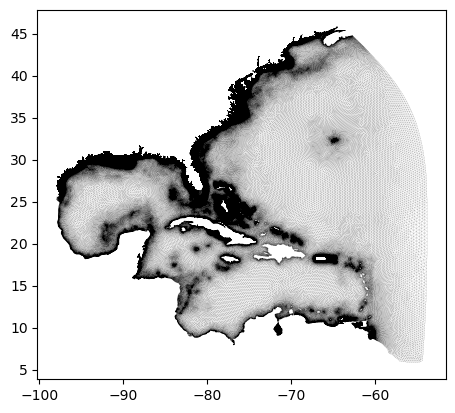

In [11]:
plot_mesh_edge(mesh_obj_1, color='k', linewidth=0.05)

<Axes: >

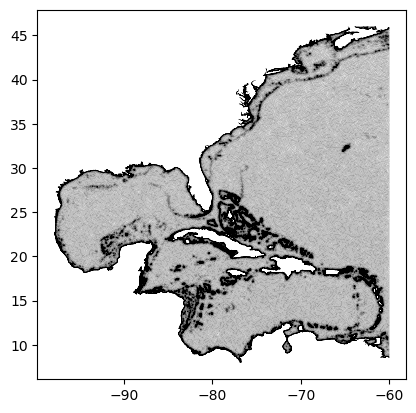

In [12]:
plot_mesh_edge(mesh_obj_2, color='k', linewidth=0.05)

<Axes: >

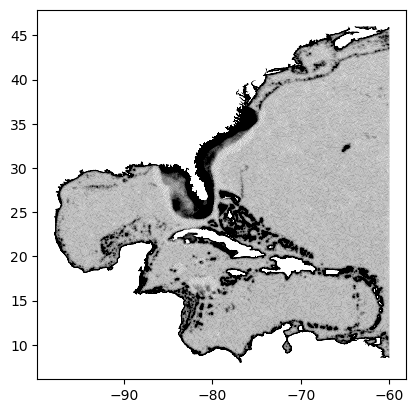

In [13]:
plot_mesh_edge(mesh_obj_3, color='k', linewidth=0.05)

## Further inspect the mesh

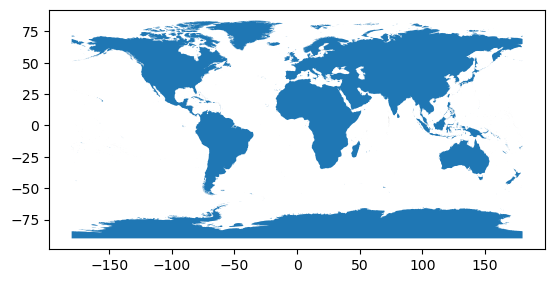

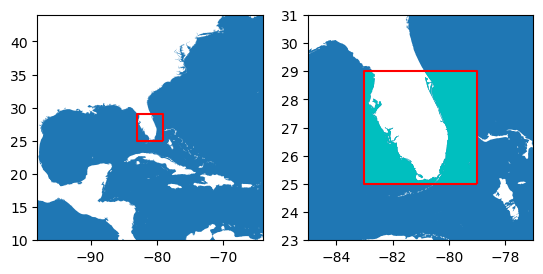

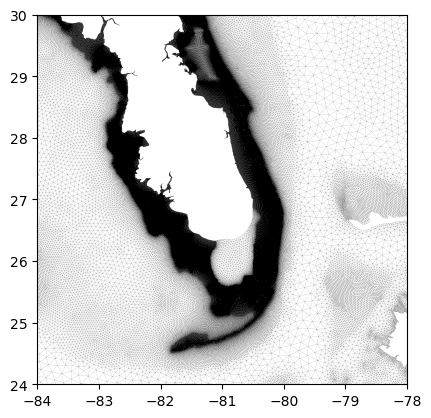

In [14]:
gdf_countries.plot()

gdf_oceans = gpd.GeoDataFrame(geometry=[geometry.box(*gdf_countries.total_bounds).difference(gdf_countries.unary_union)], crs=gdf_countries.crs)
roi_box = geometry.box(-83, 25, -79, 29)
gdf_roi_domain = gdf_oceans.intersection(roi_box)
geom_obj_1 = ocsmesh.Geom(gdf_roi_domain.unary_union, crs=gdf_roi_domain.crs)


fig_1, axs_1 = plt.subplots(1, 2)

ax = axs_1[0]
gdf_oceans.plot(ax=ax)
gpd.GeoSeries(roi_box).boundary.plot(ax=ax, color='r')
ax.set_xlim(roi_box.bounds[0] - 15, roi_box.bounds[2] + 15)
ax.set_ylim(roi_box.bounds[1] - 15, roi_box.bounds[3] + 15)
ax.set_aspect(1)

ax = axs_1[1]
gdf_oceans.plot(ax=ax)
gpd.GeoSeries(roi_box).boundary.plot(ax=ax, color='r')
gdf_roi_domain.plot(ax=ax, color='c')
ax.set_xlim(roi_box.bounds[0] - 2, roi_box.bounds[2] + 2)
ax.set_ylim(roi_box.bounds[1] - 2, roi_box.bounds[3] + 2)
ax.set_aspect(1)


fig, ax = plt.subplots(1, 1)
plot_mesh_edge(mesh_obj_3, ax=ax, color='k', linewidth=0.05)
ax.set_xlim(roi_box.bounds[0] - 1, roi_box.bounds[2] + 1)
ax.set_ylim(roi_box.bounds[1] - 1, roi_box.bounds[3] + 1)
ax.set_aspect(1)

# Assign the boundaries of the final grids

In [15]:
base_mesh = mesh_obj_3

base_mesh.boundaries.auto_generate(-10)

roi_box1 = geometry.box(-100, 0, -60, 50)
base_mesh.boundaries.set_land(region=roi_box1, merge=True)

roi_box1 = geometry.box(-60, 0, -59, 50)
base_mesh.boundaries.set_open(region=roi_box1, merge=True)

## Visualize the land, ocean and island boundaries

/tmp/ipykernel_2735/2827330853.py:10: DeprecationWarning: This is the old API and will be deprecated in the future release! Use `open()` instead
  base_mesh.boundaries.ocean().plot(ax=ax, color='b', label='Ocean')


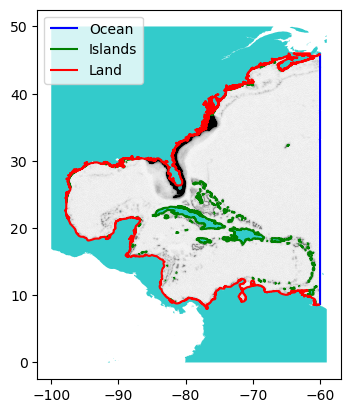

In [16]:
roi_box1 = geometry.box(-100, 0, -59, 50)


gs_region = gpd.GeoSeries(gdf_countries.unary_union.intersection(roi_box1), crs=gdf_countries.crs)

ax = gs_region.plot(color='c', alpha=0.8)

plot_mesh_edge(base_mesh.msh_t, ax=ax, lw=0.01, color='k')

base_mesh.boundaries.ocean().plot(ax=ax, color='b', label='Ocean')
base_mesh.boundaries.interior().plot(ax=ax, color='g', label='Islands')
base_mesh.boundaries.land().plot(ax=ax, color='r', label='Land')
plt.legend()

ax.set_aspect(1)

In [17]:
base_mesh.write(path_subset_outdir / 'mesh_w_bdry.gr3', format='grd', overwrite=True)

# Generate input files for the SCHISM

In [18]:
pip show pyschism

Name: pyschism
Version: 0.1.10.post2.dev0+5f3f4ae
Summary: Python package for working with SCHISM input and output files.
Home-page: https://github.com/schism-dev/pyschism.git
Author: "SCHISM development group"
Author-email: jreniel@gmail.com, lcui@vims.edu
License: "Apache 2.0"
Location: /home/smani/workarea/sandbox/pyschism
Editable project location: /home/smani/workarea/sandbox/pyschism
Requires: boto3, cdsapi, cf-python, cfgrib, f90nml, fsspec, geopandas, metpy, netcdf-flattener, netCDF4, numba, ordered-set, psutil, pygeos, pyugrid, rtree, scipy, seawater, sqlalchemy, stormevents, tqdm, tqdm-logging-wrapper, utm, wget, xarray, xmltodict, zarr
Required-by: coupledmodeldriver
Note: you may need to restart the kernel to use updated packages.


In [19]:
hgrid = pyschism.mesh.Hgrid.open(path_subset_outdir / 'mesh_w_bdry.gr3', crs=4326)

## Using ERA5 (needs user account)

Use of ERA5 requires a free account on Copernicus server, see: https://cds.climate.copernicus.eu/api-how-to

The following block sets up the model using `sflux` forcing from ERA5 databsae. This is a more generic form of model setup for wind forcing using `pyschism`

In [20]:
dramp = timedelta(days=10.)
    
        
sflux_dir = ('tidal.schism.era5/' + "sflux")
os.makedirs(sflux_dir, exist_ok=True)

era5 = ERA5()
era5.write(
    outdir=pathlib.Path(sflux_dir),
    start_date=datetime(2022,9,15),
    rnday=30,
    air=True, rad=True, prc=True,
    bbox=hgrid.bbox,
    overwrite=True)

fgrid = pyschism.mesh.ManningsN.linear_with_depth(
    hgrid,
    min_value=0.02, max_value=0.05,
    min_depth=-1.0, max_depth=-3.0)

config = pyschism.driver.ModelConfig(
    hgrid=hgrid,
    fgrid=fgrid,
    iettype=pyschism.forcing.bctides.iettype.Iettype3(database="tpxo"),
    ifltype=pyschism.forcing.bctides.ifltype.Ifltype3(database="tpxo"),
    )

coldstart = config.coldstart(
    start_date=datetime(2022,9,15) ,
    end_date=datetime(2022,10,15),       
    timestep=timedelta(seconds=150),
    dramp=dramp,
    dramp_ss=dramp,
    drampwind=dramp,
    nspool=timedelta(hours=1),
    elev=True,
    dahv=True,
    )

coldstart.write('tidal.schism.era5', overwrite=True)

windrot = gridgr3.Windrot.default(hgrid)
windrot.write('tidal.schism.era5/' + "windrot_geo2proj.gr3", overwrite=True)

## Using parametric wind

The following block sets up the model using parametric wind. Parametric wind model (GAHM or symmetric Holland) is provided through PaHM. PaHM takes a ATCF track file as input and generates wind forcing to feed to SCHISM model. This meteorological setup is best suited for Atlantic hurricane cases, such as Ian and might not be generalizable to other parts of the earth.

In [21]:
dramp = timedelta(days=10.)
    
atmospheric = BestTrackForcing.from_nhc_bdeck(nhc_bdeck='hurricane-track.dat') 

fgrid = pyschism.mesh.ManningsN.linear_with_depth(
    hgrid,
    min_value=0.02, max_value=0.05,
    min_depth=-1.0, max_depth=-3.0)

config = pyschism.driver.ModelConfig(
    hgrid=hgrid,
    fgrid=fgrid,
    iettype=pyschism.forcing.bctides.iettype.Iettype3(database="tpxo"),
    ifltype=pyschism.forcing.bctides.ifltype.Ifltype3(database="tpxo"),
    nws=atmospheric,
    )

coldstart = config.coldstart(
    start_date=datetime(2022,9,15) ,
    end_date=datetime(2022,10,15),       
    timestep=timedelta(seconds=150),
    dramp=dramp,
    dramp_ss=dramp,
    drampwind=dramp,
    nspool=timedelta(hours=1),
    elev=True,
    dahv=True,
    )

coldstart.write(Path('tidal.schism.pahm'), overwrite=True)

/home/smani/workarea/sandbox/stormevents/stormevents/nhc/track.py:173: UserWarning: It is recommended to specify the file_deck and/or advisories when reading from file
  warnings.warn(
